In [10]:
import os
import numpy as np

from pyFM.FMN import FMN
from pyFM.mesh import TriMesh
import pyFM.spectral as spectral

from tqdm.auto import tqdm

import meshplot as mp

def plot_mesh(myMesh,cmap=None):
    mp.plot(myMesh.vertlist, myMesh.facelist,c=cmap)
    
def double_plot(myMesh1,myMesh2,cmap1=None,cmap2=None):
    d = mp.subplot(myMesh1.vertlist, myMesh1.facelist, c=cmap1, s=[2, 2, 0])
    mp.subplot(myMesh2.vertlist, myMesh2.facelist, c=cmap2, s=[2, 2, 1], data=d)

def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

## Load Meshes and Maps

To Do:
will run MATLAB demo and compare:
1. if the order the meshes are being called is correct
2. if the correct maps are being loaded


also need to see how they are evaluating the results

In [12]:
mesh_list = []
for i in tqdm(range(381,401,1)):
    mesh = TriMesh(f'data/shapes/shapes/{i:02d}.off', area_normalize=True, center=True).process(k=150, intrinsic=True)
    mesh_list.append(mesh)

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
double_plot(mesh_list[0], mesh_list[1])

In [14]:
map_files = os.listdir('./data/bim_maps/bim_maps/')
index_offset = 381
maps_dict = {}
K = 30 # Size of initial functional maps, small value since our initial maps have noise - from the FMN Example

for map_file in tqdm(map_files):
    ind1, ind2s = map_file.split("_")
    ind2, _ = ind2s.split(".")
    ind1 = int(ind1); ind2 = int(ind2)

    ind1 = ind1 - index_offset; ind2 = ind2 - index_offset

    mesh1, mesh2 = mesh_list[ind1], mesh_list[ind2]
    
    p2p_21 = np.loadtxt(f'./data/bim_maps/bim_maps/{map_file}', dtype=int)

    # Convert to functional map and populate dictionary
    FM_12 = spectral.mesh_p2p_to_FM(p2p_21, mesh2, mesh1, dims=K) # so do I need to change the indices in the maps_dict??? will it be ok!!!!
    maps_dict[(ind1, ind2)] = FM_12

  0%|          | 0/380 [00:00<?, ?it/s]

In [24]:
# Display inital maps
ind_1 = 0
ind_2 = 1
mesh1, mesh2 = mesh_list[ind_1], mesh_list[ind_2]
map = maps_dict[(ind_1, ind_2)]
p2p_21 = spectral.convert.mesh_FM_to_p2p(map, mesh1, mesh2) # is this conversion causing the issue? - I think it is!!!!

#print(mesh1.vertlist)
#print(mesh2.vertlist.shape)

# print(p2p_21.shape)
# print(mesh1.vertlist.shape)
# print(mesh2.vertlist.shape)
n = p2p_21.shape[0]
p2p_map = np.eye(N=n, dtype=int)

cmap_1 = visu(mesh1.vertlist) # pointwise is 2 -> 1? so the map is applied to 2
cmap_2 = cmap_1[p2p_map]
double_plot(mesh1, mesh2, cmap_1, cmap_2)

# print(cmap_1.dtype)
# print(cmap_2.dtype)
# print(cmap_1.shape)
# print(cmap_2.shape)

# min_coord,max_coord = np.min(cmap_2,axis=0,keepdims=True),np.max(cmap_2,axis=0,keepdims=True)
# newCmap_2 = (cmap_2-min_coord)/(max_coord-min_coord)
# print(min_coord)
# print(max_coord)

p2p_21_1 = np.loadtxt(f'./data/bim_maps/bim_maps/382_381.map', dtype=int)
cmap_1 = visu(mesh2.vertlist)
cmap_2_1 = cmap_1[p2p_map]

double_plot(mesh2, mesh2, cmap_1, cmap_2_1)

Invalid color array given! Supported are numpy arrays. <class 'numpy.ndarray'>


Invalid color array given! Supported are numpy arrays. <class 'numpy.ndarray'>


In [9]:
from pyFM.functional import FunctionalMapping

# Display inital maps
ind_1 = 1
ind_2 = 3
mesh1, mesh2 = mesh_list[ind_1], mesh_list[ind_2]

process_params = {
    'n_ev': (35,35),  # Number of eigenvalues on source and Target
    'landmarks': np.loadtxt('../../pyFM/examples/data/landmarks.txt',dtype=int)[:5],  # loading 5 landmarks
    'subsample_step': 5,  # In order not to use too many descriptors
    'descr_type': 'WKS',  # WKS or HKS
}
model = FunctionalMapping(mesh1,mesh2)
#model.preprocess(**process_params,verbose=True);

fit_params = {
    'w_descr': 1e0,
    'w_lap': 1e-2,
    'w_dcomm': 1e-1,
    'w_orient': 0
}

model.fit(**fit_params, verbose=True)


p2p_21 = model.get_p2p(n_jobs=1)

cmap_1 = visu(mesh1.vertlist) # pointwise is 2 -> 1? so the map is applied to 2
cmap_2 = cmap_1[p2p_21]
double_plot(mesh1, mesh2, cmap_1, cmap_2)


Computing commutativity operators
	Scaling LBO commutativity weight by 6.0e-09

Optimization :
	50 Ev on source - 50 Ev on Target
	Using 100 Descriptors
	Hyperparameters :
		Descriptors preservation :1.0e+00
		Descriptors commutativity :1.0e-01
		Laplacian commutativity :1.0e-02
		Orientation preservation :0.0e+00

	Task : CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH, funcall : 152, nit : 145, warnflag : 0
	Done in 1.22 seconds


## Analyse the Embeddings
before applying CZ

Will probably just make this a function to apply in the analysis stages of the project

In [78]:
# Build the network
fmn_model = FMN(mesh_list, maps_dict.copy())

# Compute CCLB
fmn_model.compute_CCLB(m=20)

Setting 380 edges on 20 nodes.
Computing cycle information
Optimizing Cycle Weights...
	Done in 0.09687s
Computing 30 CLB eigenvectors...
	Done in 0.1s


In [79]:
# embedding for area and conformal charecteristic shape difference operator using the CCLB
# will we have an embedding for sequences and stuff here then? - or is that supposed to be an alterative to the CCLB or something
all_embs_a = []
all_embs_c = []

for i in range(fmn_model.n_meshes):
    CSD_a, CSD_c = fmn_model.get_CSD(i)

    all_embs_a.append(CSD_a.flatten())
    all_embs_c.append(CSD_c.flatten())

all_embs_a = np.array(all_embs_a)
all_embs_c = np.array(all_embs_c)

Text(0.5, 1.0, 'Conformal CSD')

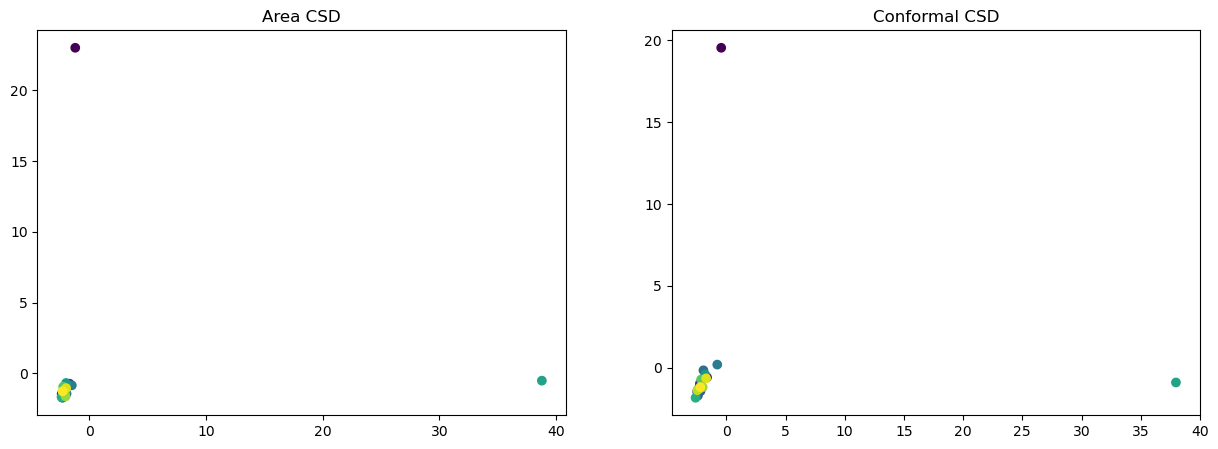

In [80]:
# Apply PCA (Principal Component Analysis) on the embedding to visualize the results
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2)
emb_red_a = pca_model.fit_transform(all_embs_a)
emb_red_c = pca_model.fit_transform(all_embs_c)

# Display
_, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(emb_red_a[:, 0], emb_red_a[:, 1], c=np.arange(len(emb_red_a)))
axs[0].set_title('Area CSD')

axs[1].scatter(emb_red_c[:, 0], emb_red_c[:, 1], c=np.arange(len(emb_red_c)))
axs[1].set_title('Conformal CSD')

## Consistent Zoomout

the matlab demo uses:
iterations = 25
zoomout =  from dim 30 to 80 with step of 2
subsample = 1000
weights = icsm
alpha = 0.9

In [90]:
fmn_model.zoomout_refine(nit=25, step=2, subsample=1000, isometric=True, weight_type='icsm',
                    M_init=None, cclb_ratio=.9, n_jobs=1, equals_id=False,
                    verbose=True)

fmn_model.compute_CCLB(m=int(0.9*fmn_model.M))
fmn_model.cclb_eigenvalues.shape

Computing a 1000-sized subsample for each mesh


  0%|          | 0/24 [00:00<?, ?it/s]

Optimizing Cycle Weights...
	Done in 0.10495s
Computing 96 CLB eigenvectors...
	Done in 1.0s


(86,)

In [91]:
# to save the model
import pickle as p
# save
with open("../../fmn_model_CZ.pkl", "wb") as f:
    p.dump(fmn_model, f)

# # load
# with open("../../fmn_model_CZ.pkl", "rb") as f:
#     fmn_model = p.load(f)

Analyse the embeddings after CZ

In [92]:
all_embs_a = []
all_embs_c = []

for i in range(fmn_model.n_meshes):
    CSD_a, CSD_c = fmn_model.get_CSD(i)

    all_embs_a.append(CSD_a.flatten())
    all_embs_c.append(CSD_c.flatten())

all_embs_a = np.array(all_embs_a)
all_embs_c = np.array(all_embs_c)

Text(0.5, 1.0, 'Conformal CSD')

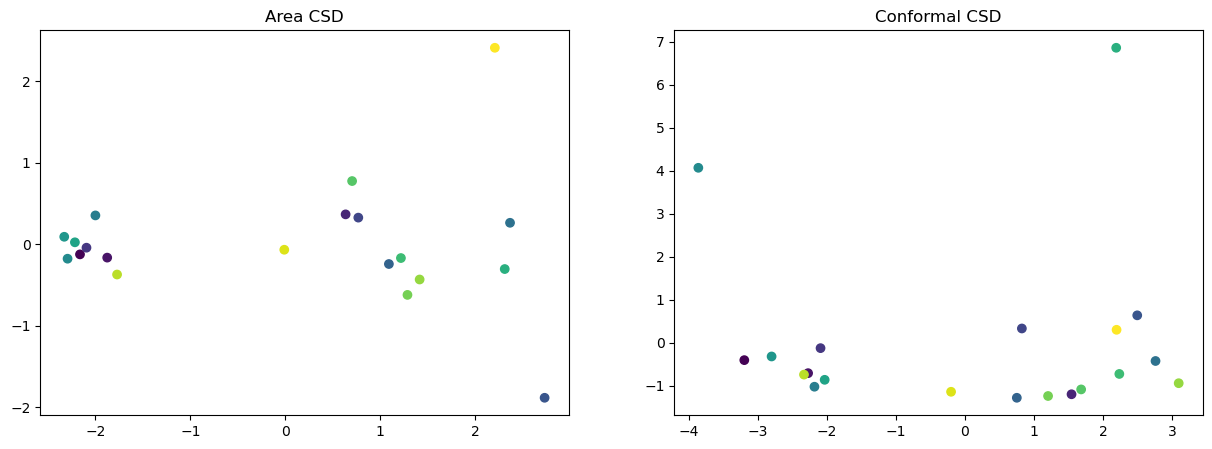

In [93]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2)
emb_red_a = pca_model.fit_transform(all_embs_a)
emb_red_c = pca_model.fit_transform(all_embs_c)

_, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(emb_red_a[:, 0], emb_red_a[:, 1], c=np.arange(len(emb_red_a)))
axs[0].set_title('Area CSD')

axs[1].scatter(emb_red_c[:, 0], emb_red_c[:, 1], c=np.arange(len(emb_red_c)))
axs[1].set_title('Conformal CSD')

In [118]:
# For Display
ind_1 = 1 # mesh 2 is the horse
ind_2 = 3 # mesh 4 is the wolf

new_maps_dict = fmn_model.maps
map = new_maps_dict[ind_1, ind_2]
mesh1, mesh2 = mesh_list[ind_1], mesh_list[ind_2]

p2p_21 = spectral.convert.mesh_FM_to_p2p(map, mesh1, mesh2)

cmap_1 = visu(mesh1.vertlist) # pointwise is 2 -> 1? so the map is applied to ?
cmap_2 = cmap_1[p2p_21]
double_plot(mesh1, mesh2, cmap_1, cmap_2)

# for idx, map in tqdm(new_maps_dict):
#     print(idx)

    # # Retrive corresponding meshes
    # mesh1, mesh2 = mesh_list[ind_1], mesh_list[ind_2]

    # # Display maps
    # if ind_1 < 1 and ind_2 < 2:
    #     # Convert to p2p
    #     p2p_map = spectral.convert.mesh_FM_to_p2p(map, mesh2, mesh1, subsample=3000)
        
    #     cmap_2 = visu(mesh2.vertlist) # pointwise is 2 -> 1? 
    #     cmap_1 = cmap_2[p2p_map]
    #     double_plot(mesh2, mesh1, cmap_2, cmap_1)
    
    